# Check of ISIMIP3b histsoc population 

More info on dataset: https://data.isimip.org/datasets/a456276c-b0f8-4cee-af11-52a6dfcf1f38/

*"The population data are adopted from HYDE v3.3 (private communication with K. Klein Goldewijk, to be published). Just like the original dataset we provide total, rural and urban population per grid cell. The original data was on a 1/12°×1/12° grid and has been interpolated to ISIMIP's 1/2°×1/2° grid via cdo remapcon. Furthermore, the map was modified to comply with the ISIMIP fractional land-sea-mask (Perrette 2022).*

*Before the year 2000 HYDE provides data every ten years, the intermediate years have been filled by linear interpolation. Also, the original HYDE data ends in 2020, so to cover the whole ISIMIP3a time frame the final year 2020 has been duplicated as 2021. This way annual coverage of 1850 to 2021 has been achieved.*

*All grid cells of a country, as defined by the ISIMIP fractional country map (Perrette 2022), have been rescaled such that the country's total population matches the numbers provided in the national population data (United Nations 2009). Since the national data only starts in 1950, all years prior to 1950 have been rescaled by the scaling factors of 1950.*"

Caveats with data: https://data.isimip.org/caveats/10/ 

SSPs are not yet available (May 2023)

### **TO DO** 
* consistent testing of dataset (development of metrics and scripts that make more sense)
* check whether GDP is available
* check simulated histsoc domestic and industrial demand form GHMs (





In [21]:
# import modules
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
%matplotlib inline 
map_proj = ccrs.Robinson(central_longitude=0, globe=None)


In [22]:
# define coordinates of individual gridcells to plot timeseries of

cell_saudi = [21.25, 49.75] # grid cell lat lon coordinates: Grid cell in Saudi-Arabia
cell_france = [50.75,4.75]
cell_kazachstan = [47.75, 81.25]

cells_toplot = [cell_saudi, cell_france,  cell_kazachstan ]
names_toplot = ['Saudi',      'France',    'Kazachstan']

## 0. Functions

In [23]:
# functions to plot individual grid cells

# wrapper plotting script for plotting individual grid cells 
def plot_cell_series(da, cells_toplot, names_toplot):
    fig, axes = plt.subplots(1,len(cells_toplot), figsize=(7*len(cells_toplot),4))

    for i, ax in enumerate(axes): 
        plot_gridcell_timeseries(ax, da, cells_toplot[i], names_toplot[i])

# plot timeseries of data array for single grid cell 
def plot_gridcell_timeseries(ax, da, cell_coord, name): 
    da.sel({'lat':cell_coord[0],'lon':cell_coord[1]}).plot(ax=ax)
    ax.set_title(name+ ' grid cell')
    #ax.axvline(2000, color='grey')    
    
def plot_globalsum_timeseries(da): 
    fig,ax = plt.subplots()
    da.sum(dim=('lat','lon')).plot()
    ax.set_title('global sum')

## 1. Population
Original population as provided in ISIMIP3b. This is used directly in the hydrological model simulations. 

In [47]:
pop = xr.open_dataset('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/isimip2b_population_correction/data/isimip3b/population_histsoc_30arcmin_annual_1901_2021.nc')['total-population']
pop

<xarray.DataArray 'total-population' (time: 121, lat: 360, lon: 720)>
[31363200 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 1901-01-01T12:00:00 ... 2021-01-01T12:00:00
Attributes:
    units:          1
    standard_name:  total population

### Spatial year-to-year transitions

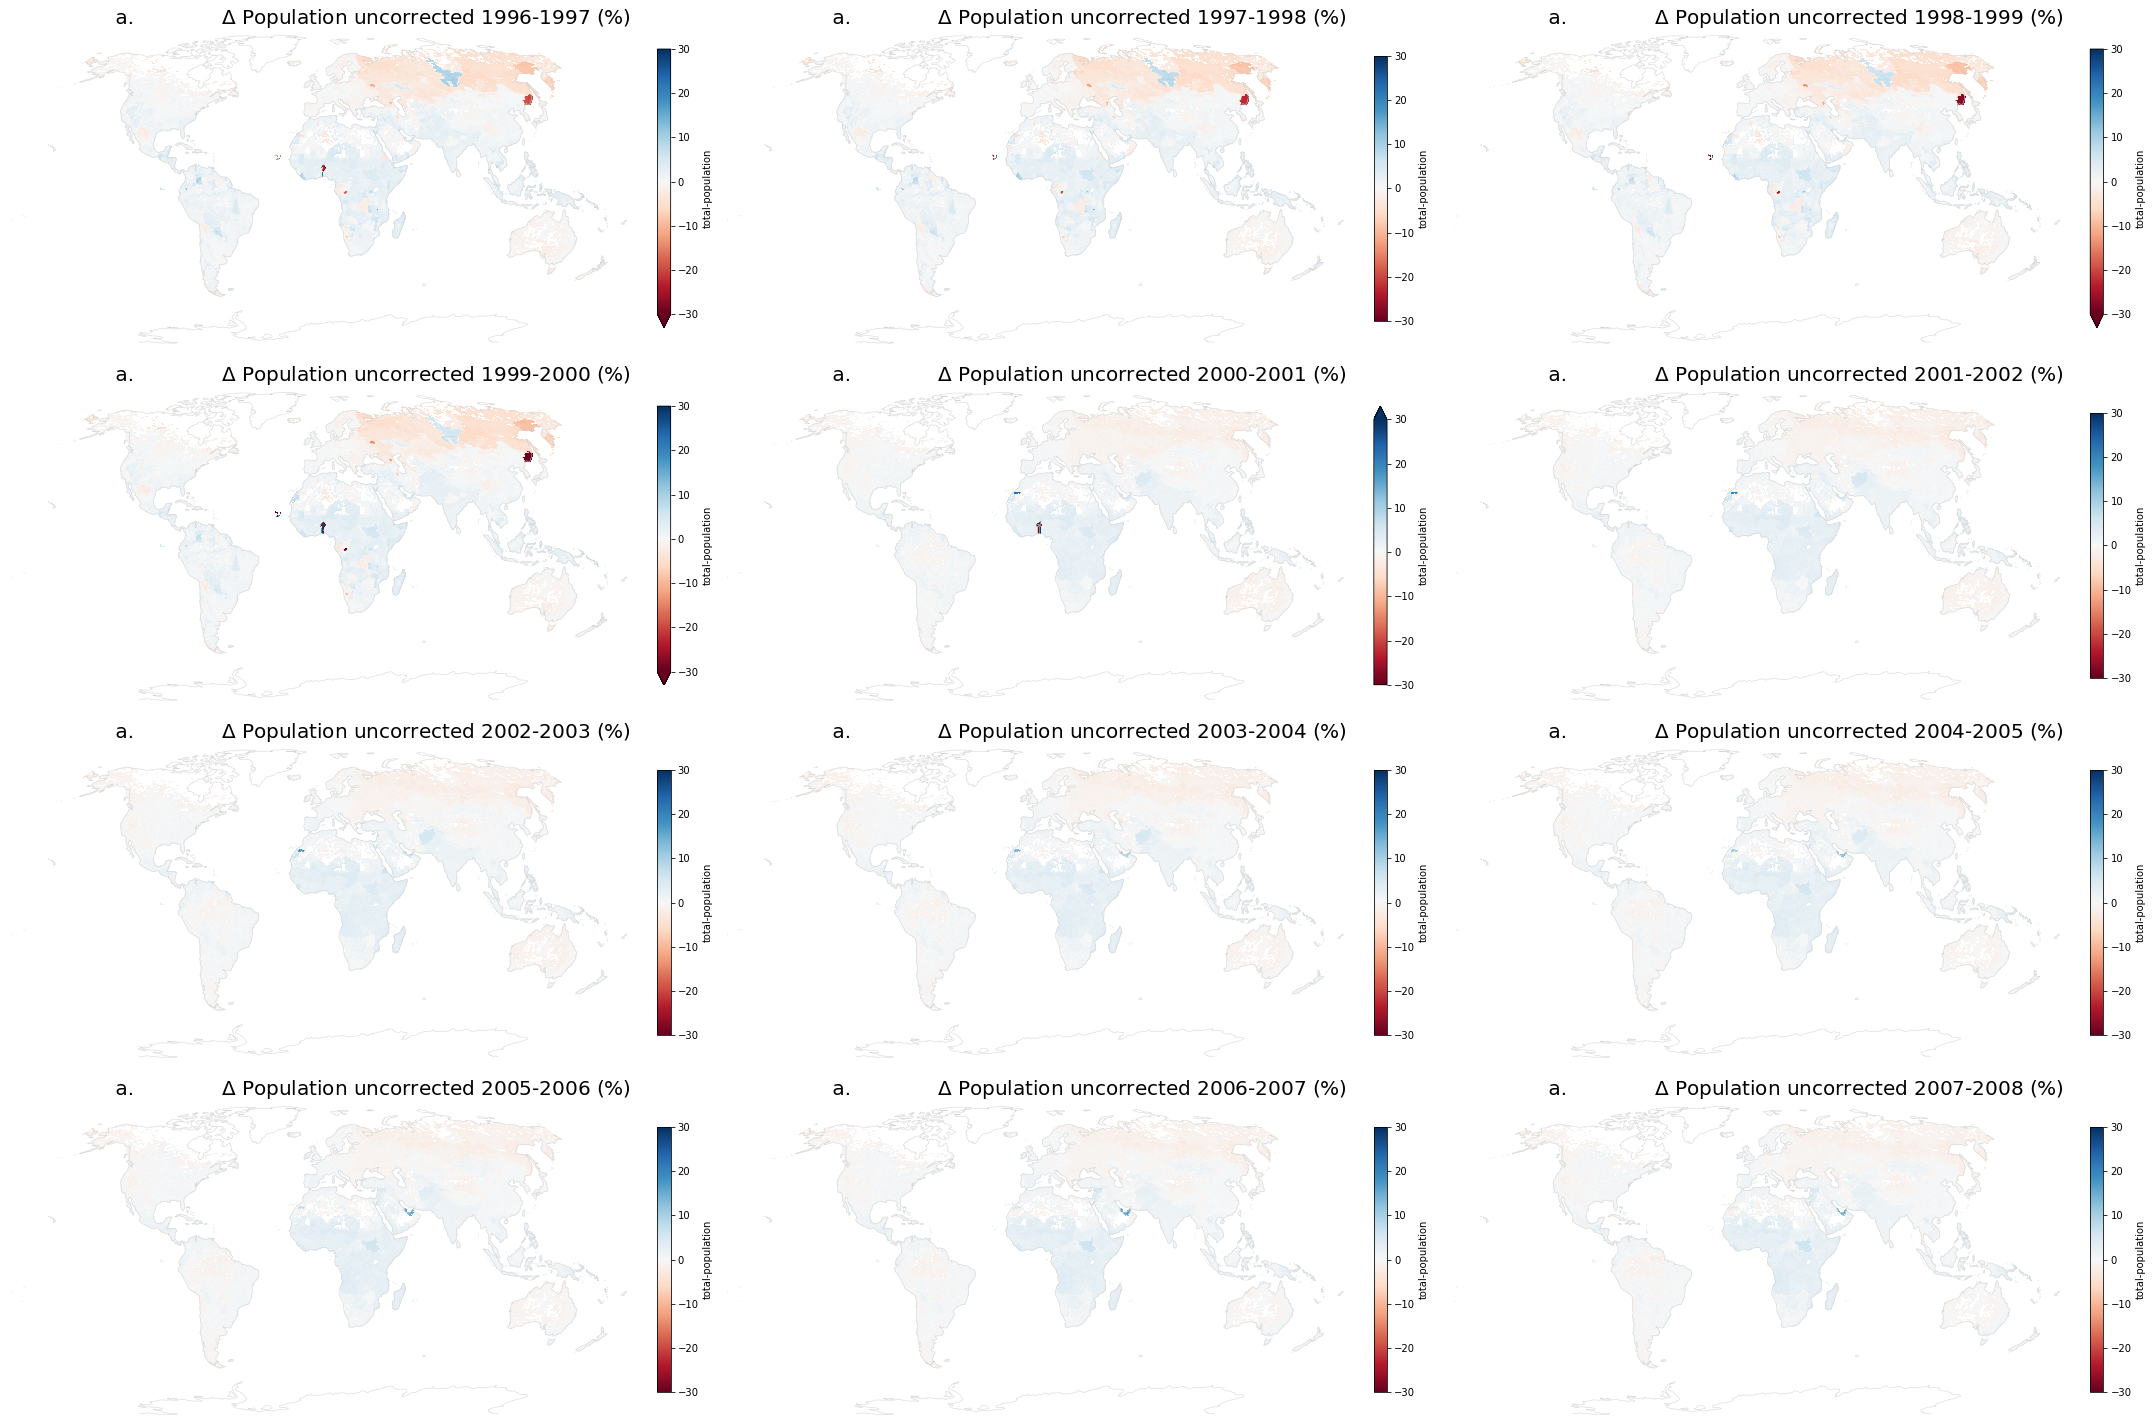

In [48]:
ww = pop
years = range(1996,2008)
variable_name = 'Population uncorrected'

fig, axes = plt.subplots(4,3,figsize=(30,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()


for i, year in enumerate(years):
    
    ax = axes[i]


    ww_year = ww.sel(time=str(year)+"-01-01").squeeze()
    ww_year2 = ww.sel(time=str(year+1)+"-01-01").squeeze()

    delta = (ww_year2 - ww_year)/ww_year *100

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    delta.plot(ax=ax, cbar_kwargs={'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmin=-30, vmax=30, transform=ccrs.PlateCarree())
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('');
    ax.set_title('$\Delta$ ' +variable_name+' '+str(year)+'-'+str(year+1)+' (%)', loc='right', fontsize=20);
    ax.set_title('                 a.', loc='left', fontsize=20);
fig.tight_layout()




### Plot timeseries for individual grid cells and global mean

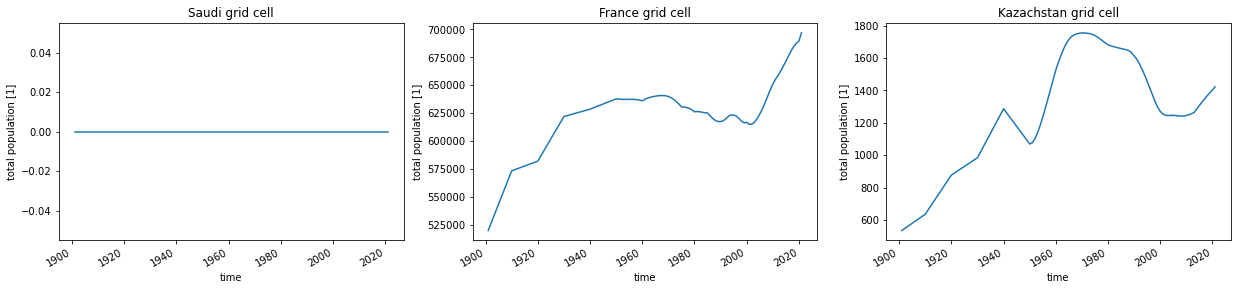

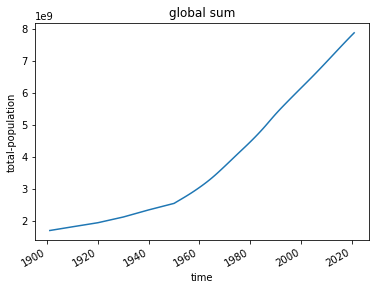

In [27]:
# define variable to plot 
da = pop

# do plotting
plot_cell_series(da, cells_toplot, names_toplot)
plot_globalsum_timeseries(da)

## 2. Simulated histsoc domestic and industrial water demands H08, here showcased for IPSL-CM6a-LR

In [43]:
domww = xr.open_dataset('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/OutputData/water_global/H08/ipsl-cm6a-lr/historical/h08_ipsl-cm6a-lr_w5e5_historical_histsoc_default_adomww_global_monthly_1850_2014.nc', decode_times=False)['adomww']
indww = xr.open_dataset('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/OutputData/water_global/H08/ipsl-cm6a-lr/historical/h08_ipsl-cm6a-lr_w5e5_historical_histsoc_default_amanww_global_monthly_1850_2014.nc', decode_times=False)['amanww']


In [44]:
# assign right timing for comparison purposes
domww = domww.assign_coords(time = pd.date_range(start='1850', end='2015', freq='M')).groupby('time.year').mean()
indww = indww.assign_coords(time = pd.date_range(start='1850', end='2015', freq='M')).groupby('time.year').mean()


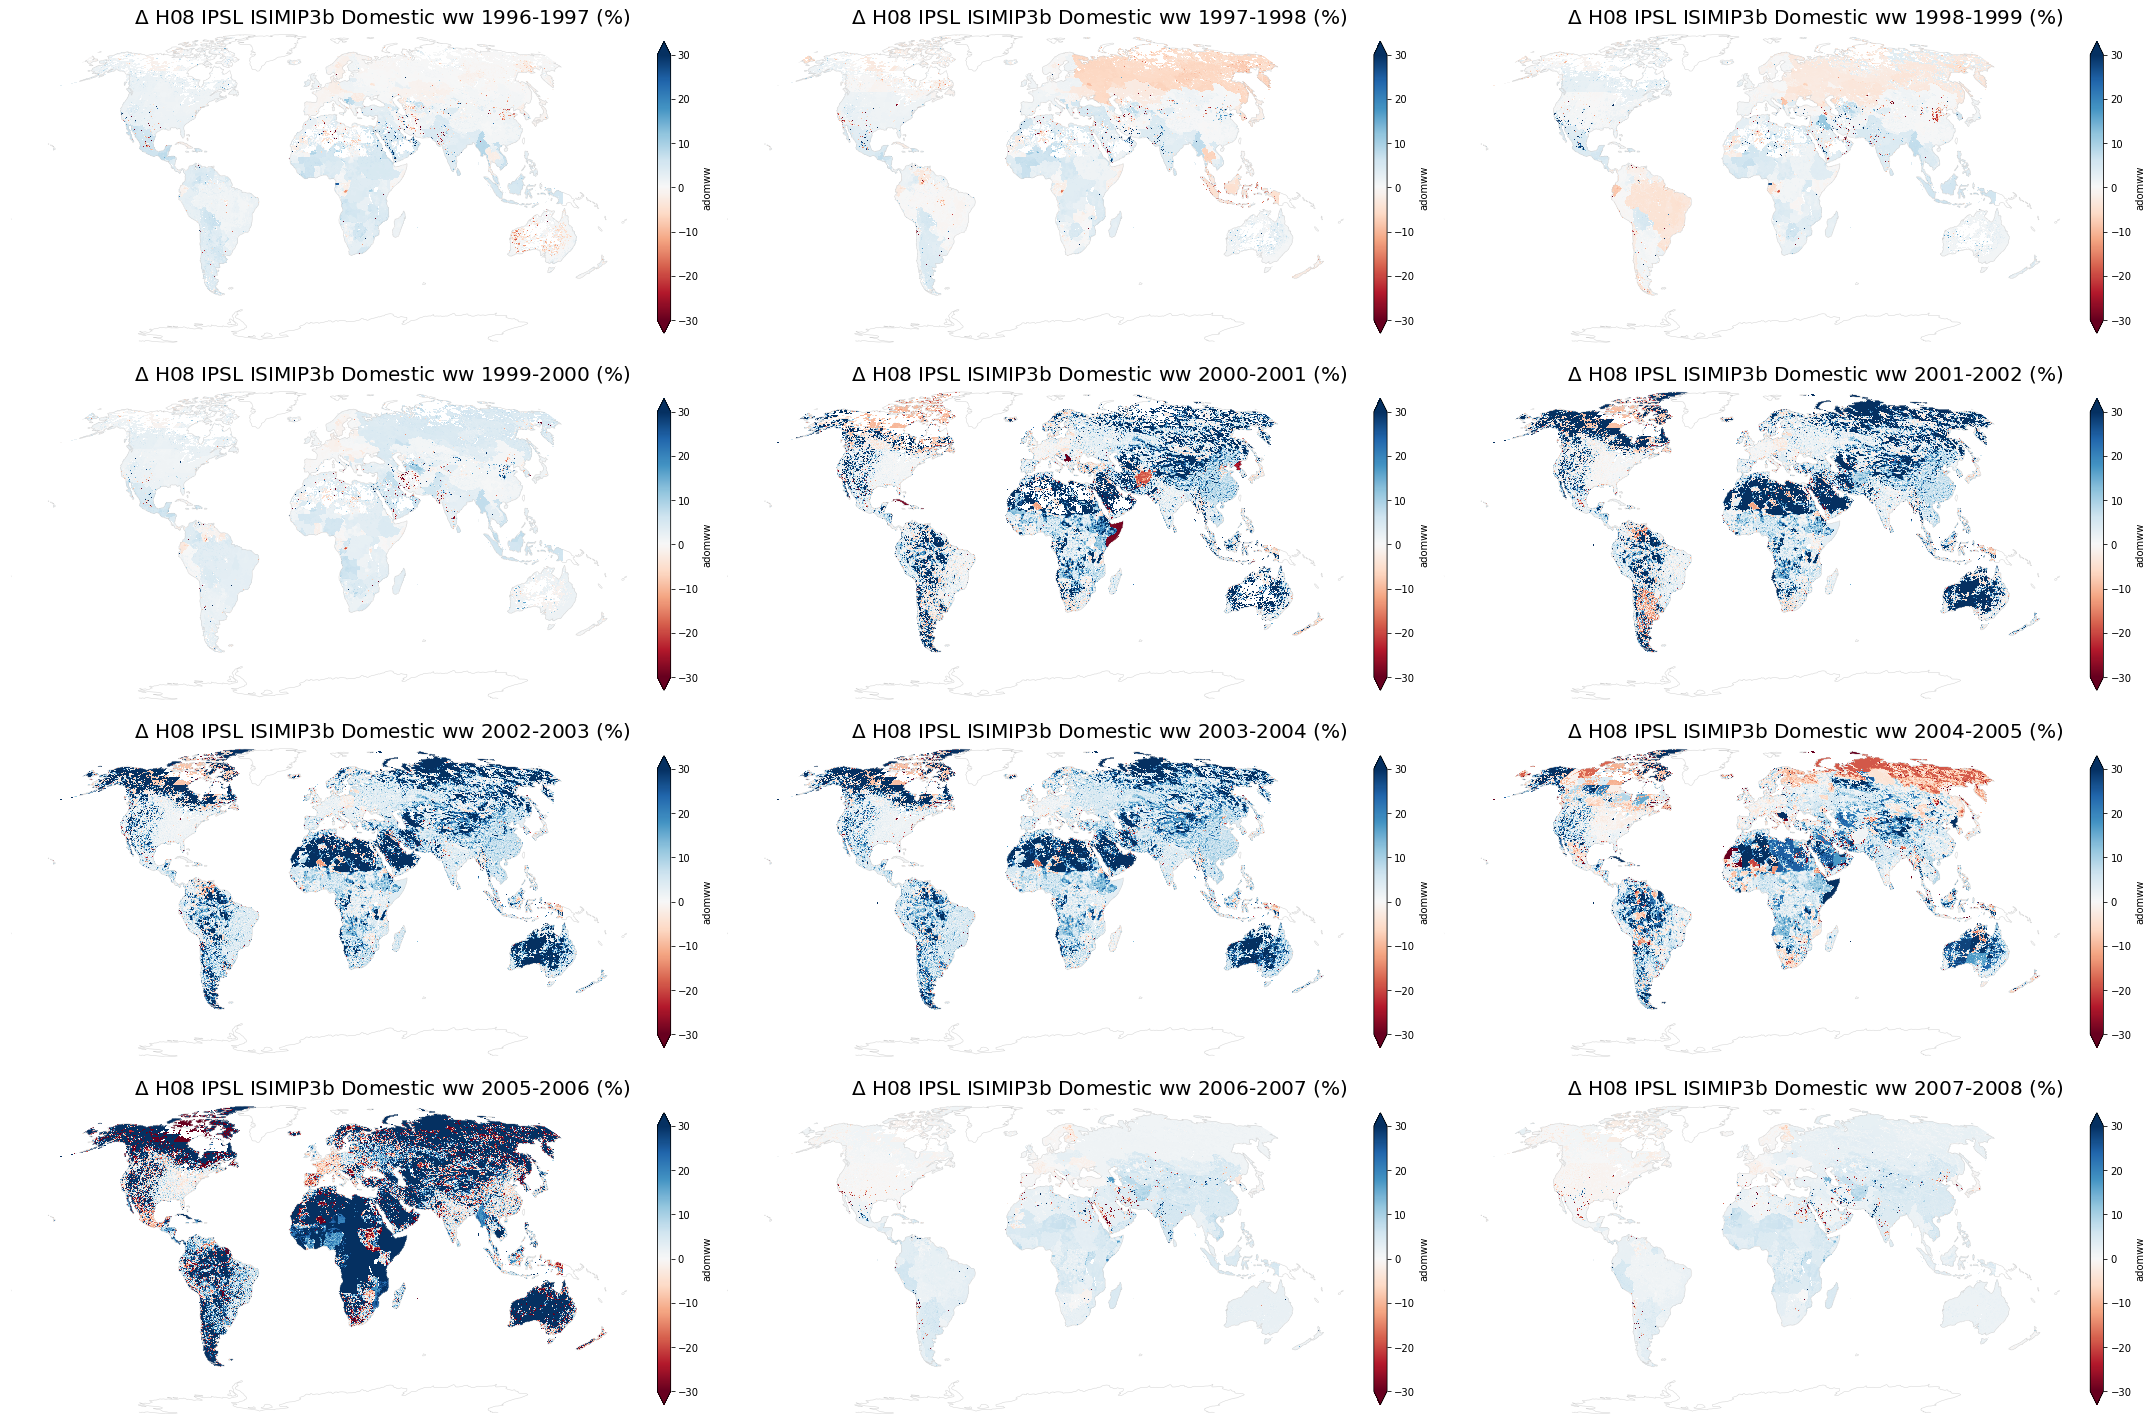

In [45]:
variable_name = 'H08 IPSL ISIMIP3b Domestic ww'
ww = domww

years = range(1996,2008)

fig, axes = plt.subplots(4,3,figsize=(30,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()


for i, year in enumerate(years):
    
    ax = axes[i]


    ww_year = ww.sel(year=year).squeeze()
    ww_year2 = ww.sel(year=year+1).squeeze()

    delta = (ww_year2 - ww_year)/ww_year *100

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    delta.plot(ax=ax, cbar_kwargs={'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmin=-30, vmax=30, transform=ccrs.PlateCarree())
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('');
    ax.set_title('$\Delta$ ' +variable_name+' '+str(year)+'-'+str(year+1)+' (%)', loc='right', fontsize=20);
fig.tight_layout()

plt.savefig('../results/isimip3b_H08_domww_delta.pdf', format='pdf')



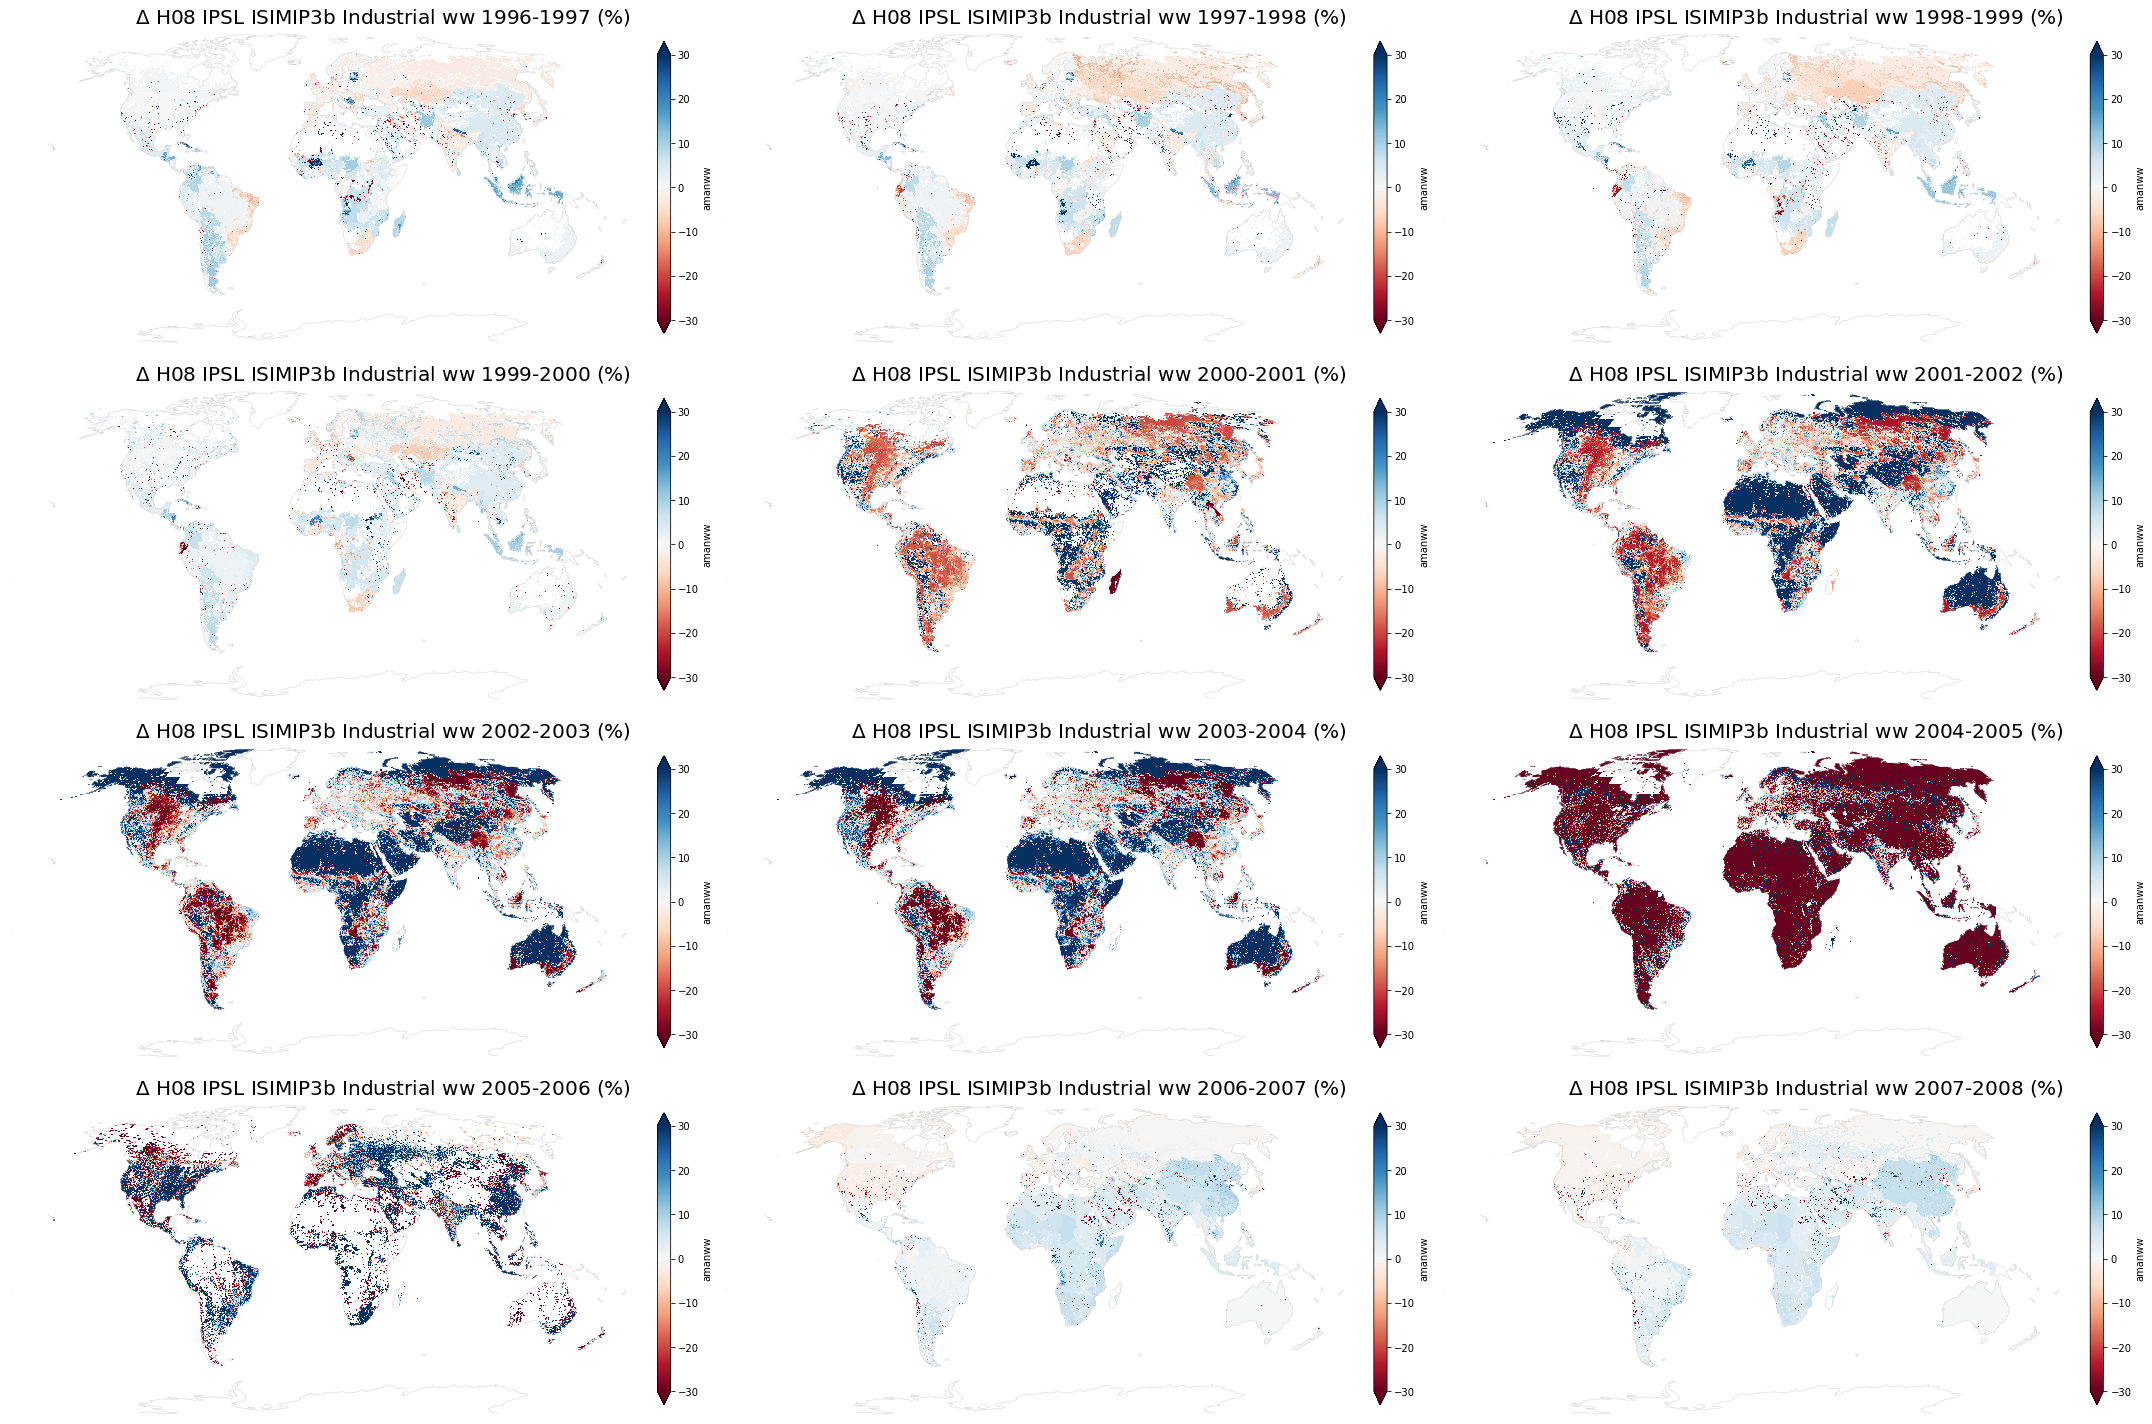

In [46]:
variable_name = 'H08 IPSL ISIMIP3b Industrial ww'
ww = indww

years = range(1996,2008)

fig, axes = plt.subplots(4,3,figsize=(30,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()


for i, year in enumerate(years):
    
    ax = axes[i]

    ww_year = ww.sel(year=year).squeeze()
    ww_year2 = ww.sel(year=year+1).squeeze()

    delta = (ww_year2 - ww_year)/ww_year *100

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    delta.plot(ax=ax, cbar_kwargs={'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmin=-30, vmax=30, transform=ccrs.PlateCarree())
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('');
    ax.set_title('$\Delta$ ' +variable_name+' '+str(year)+'-'+str(year+1)+' (%)', loc='right', fontsize=20);
fig.tight_layout()

plt.savefig('../results/isimip3b_H08_indww_delta.pdf', format='pdf')



### Plot timeseries for individual grid cells and global mean

DOMESTIC


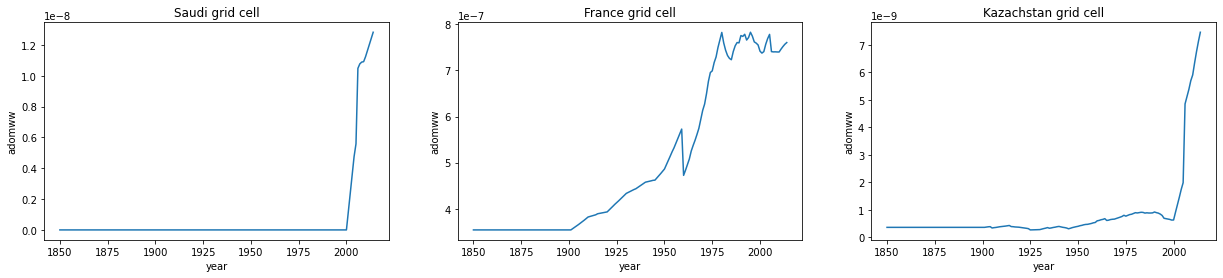

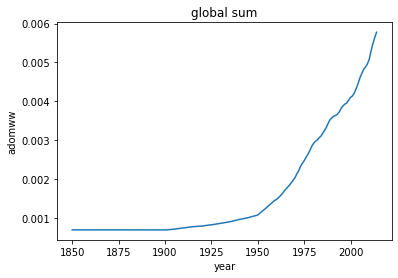

In [271]:
# define variable to plot 
da = domww

print('DOMESTIC')

# do plotting
plot_cell_series(da, cells_toplot, names_toplot)

plot_globalsum_timeseries(da)

INDUSTRIAL


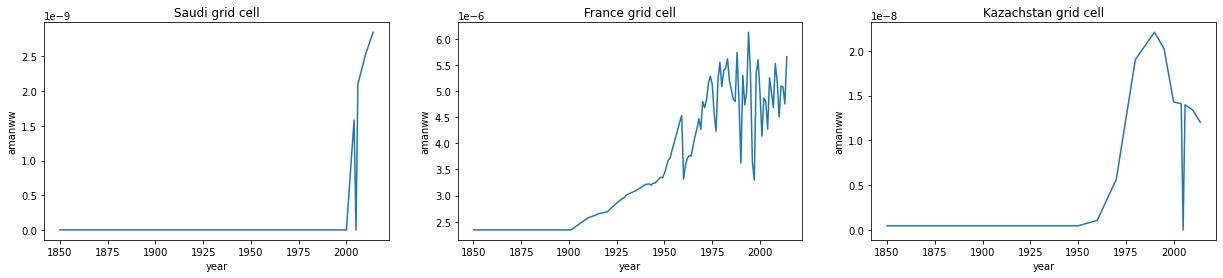

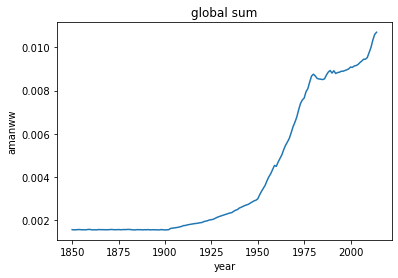

In [272]:
# define variable to plot 
da = indww

print('INDUSTRIAL')

# do plotting
plot_cell_series(da, cells_toplot, names_toplot)

plot_globalsum_timeseries(da)

## 3. Simulated histsoc domestic and industrial water demands WaterGAP, here showcased for UKESM

In [38]:
domww = xr.open_dataset('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/OutputData/water_global/WaterGAP2-2e/ukesm1-0-ll/historical/watergap2-2e_ukesm1-0-ll_w5e5_historical_histsoc_default_pdomww_global_monthly_1850_2014.nc', decode_times=False)['pdomww']
indww = xr.open_dataset('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/OutputData/water_global/WaterGAP2-2e/ukesm1-0-ll/historical/watergap2-2e_ukesm1-0-ll_w5e5_historical_histsoc_default_pmanww_global_monthly_1850_2014.nc', decode_times=False)['pmanww']


In [39]:
# assign right timing for comparison purposes
domww = domww.assign_coords(time = pd.date_range(start='1850', end='2015', freq='M')).groupby('time.year').mean()
indww = indww.assign_coords(time = pd.date_range(start='1850', end='2015', freq='M')).groupby('time.year').mean()


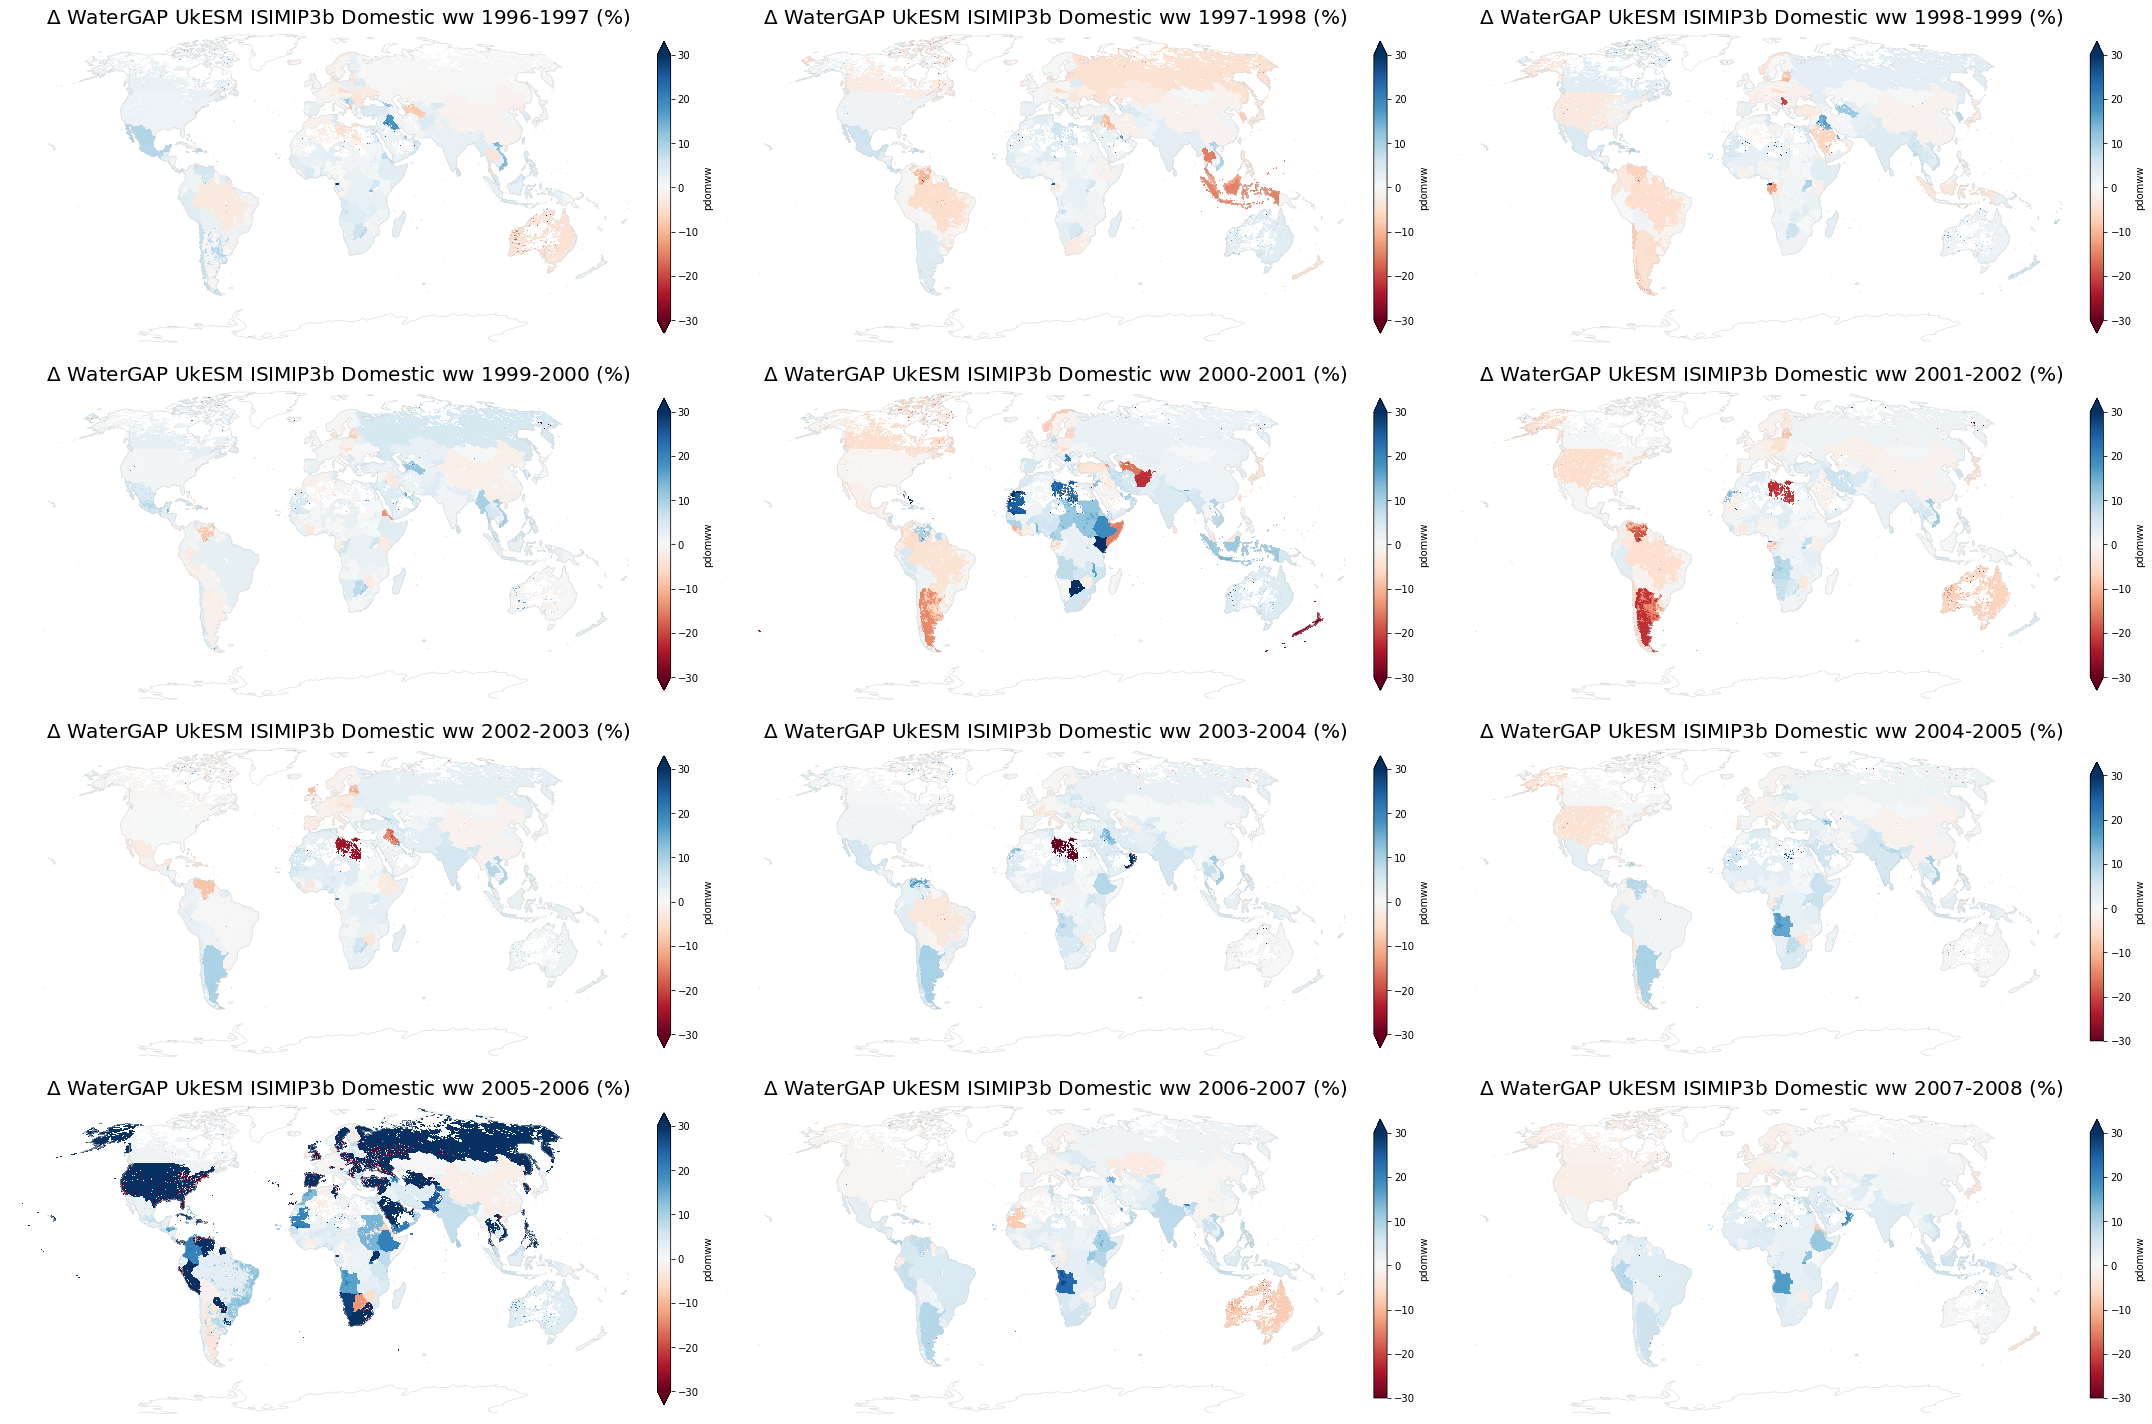

In [41]:
variable_name = 'WaterGAP UkESM ISIMIP3b Domestic ww'
ww = domww

years = range(1996,2008)

fig, axes = plt.subplots(4,3,figsize=(30,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()


for i, year in enumerate(years):
    
    ax = axes[i]


    ww_year = ww.sel(year=year).squeeze()
    ww_year2 = ww.sel(year=year+1).squeeze()

    delta = (ww_year2 - ww_year)/ww_year *100

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    delta.plot(ax=ax, cbar_kwargs={'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmin=-30, vmax=30, transform=ccrs.PlateCarree())
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('');
    ax.set_title('$\Delta$ ' +variable_name+' '+str(year)+'-'+str(year+1)+' (%)', loc='right', fontsize=20);
fig.tight_layout()

plt.savefig('../results/isimip3b_WaterGAP_domww_delta.pdf', format='pdf')



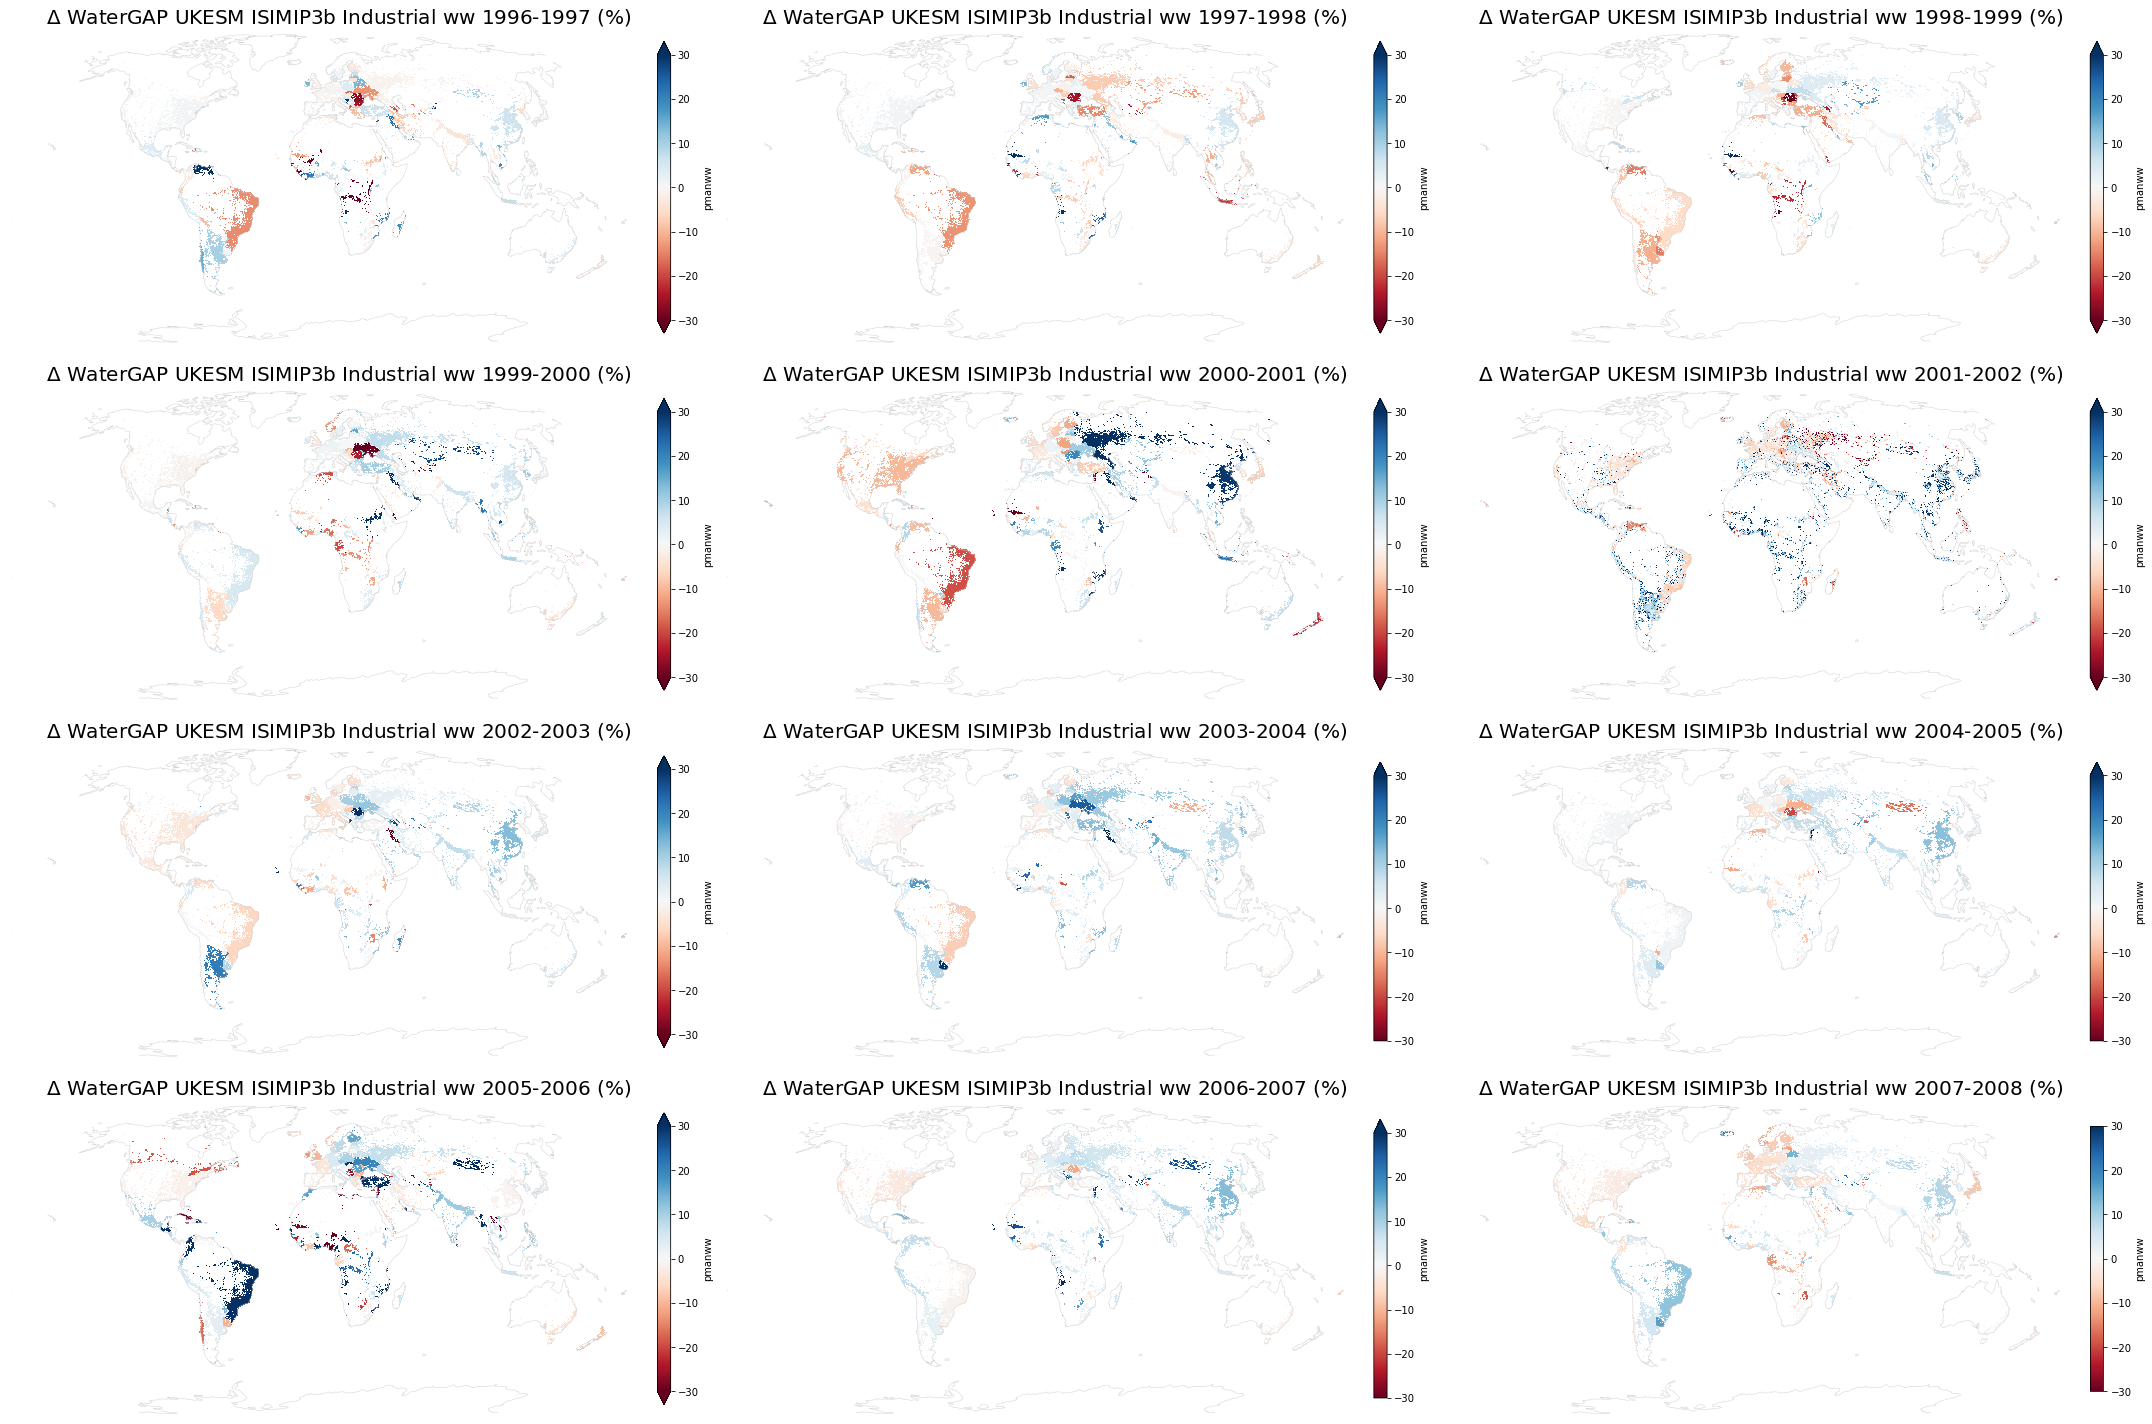

In [42]:
variable_name = 'WaterGAP UKESM ISIMIP3b Industrial ww'
ww = indww

years = range(1996,2008)

fig, axes = plt.subplots(4,3,figsize=(30,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()


for i, year in enumerate(years):
    
    ax = axes[i]

    ww_year = ww.sel(year=year).squeeze()
    ww_year2 = ww.sel(year=year+1).squeeze()

    delta = (ww_year2 - ww_year)/ww_year *100

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    delta.plot(ax=ax, cbar_kwargs={'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmin=-30, vmax=30, transform=ccrs.PlateCarree())
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('');
    ax.set_title('$\Delta$ ' +variable_name+' '+str(year)+'-'+str(year+1)+' (%)', loc='right', fontsize=20);
fig.tight_layout()

plt.savefig('../results/isimip3b_WaterGAP_indww_delta.pdf', format='pdf')

